# Paper: Automated Detection of Alzheimer’s via Hybrid Classical Quantum Neural Networks by Tayyaba Shahwar, Jinaid Zafar at al.

## Hybrid Quantum Neural Network for Alzheimer's desease detection

Deep Neural Networks have offered numerous innovative solutions to medicine and brain-deseases detection including Alzheimer's. Nevertheless there are goals and problems need to be solved and developed to achive better results. Fortunatly, they can be solved using quatum algorithms in the combination with classical methods.

The authors of the paper offer the following model:
    Classical DL pretrained model ResNet34 acts as feature exctractor: 512-feature vector is fed to a quantum variational circuit. Quantum circuit transforms a 512-feature vector into 4-feature vector to fit it into a fully connected layer that generates the final prediction.


## Dataset
In this work the authors used open source dataset from Kaggle containing 6400 labeled MRI brain images. Dataset is availebel to download from Kaggle: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

Dataset is split into **train** and **test**

All the images are devided into four groups:

    1. Non Demented - desease does not exsists
    2. Mild Demented - first stage
    2. Very Mild Demented - second stage
    3. Moderate Demented - the last stage - most obvious to detect

In the current work to repeat results for a binary clssification I used only two groups: Non Demented and Moderate Demented



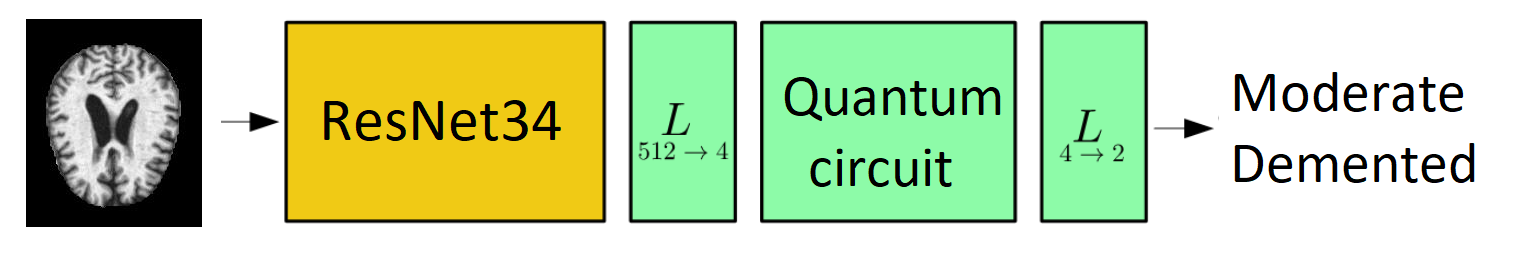

In [1]:
! pip install pennylane 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 84.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 KB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 86.1 MB/s eta 0:00:00


In [2]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import os
import copy

env: OMP_NUM_THREADS=1


In [3]:
n_qubits = 4                     # Number of qubits
quantum = True                   # If set to "False", the dressed quantum circuit is replaced by 
                                 # An enterily classical net (defined by the next parameter). 
classical_model = '512_nq_2'     # Possible choices: '512_2','512_nq_2','551_512_2'. 
step = 0.0004                    # Learning rate
batch_size = 4                   # Number of samples for each training step
num_epochs = 1  # 30                 # Number of training epochs
q_depth = 6                      # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1         # Learning rate reduction applied every 10 epochs.                       
max_layers = 15                  # Keep 15 even if not all are used.
q_delta = 0.01                   # Initial spread of random quantum weights
rng_seed = 0                     # Seed for random number generator
start_time = time.time()         # Start of the computation timer

In [19]:
resnet_balanced_acc = []
resnet_balanced_loss = []
resnet_nonbalnced_acc = []
resnet_nonbalanced_loss = []

cq_balanced_acc = []
cq_balanced_loss = []
cq_nonbalanced_acc = []
cq_nonbalanced_loss = []

To use quantum semulator we nead to initialize pannylane device. Here I initialize a default qubit device

In [4]:
dev = qml.device('default.qubit', wires=n_qubits)

Connect Cuda to use GPU

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data loading and preprocessing

In [6]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),     # uncomment for data augmentation
        #transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # Normalize input channels using mean values and standard deviations of ImageNet.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Colab Notebooks/diploma/Alzheimer_s Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                     data_transforms[x]) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

## Data visualization


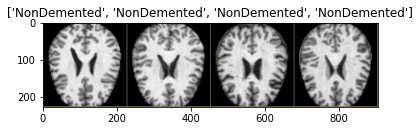

In [7]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
torch.manual_seed(rng_seed)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size,shuffle=True) for x in ['train', 'val']}

## Classical ResNet34

In [16]:
def train_classic_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    min_loss = 1.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                if min_loss < epoch_loss:
                    min_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    # return model
    return best_acc, min_loss

In [17]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
for step in range(1, 2, 1):
    acc, loss = train_classic_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=step)
    resnet_balanced_acc.append(acc)
    resnet_balanced_loss.append(loss)

with open('resnet_balanced_acc.txt', 'w') as file:
    for acc in resnet_balanced_acc:
        file.write(f'{acc},')

with open('resnet_balanced_loss.txt', 'w') as file:
    for loss in resnet_balanced_loss:
        file.write(f'{loss},')

Epoch 0/0
----------
train Loss: 0.0010 Acc: 1.0000
val Loss: 0.0091 Acc: 0.9969

Training complete in 0m 36s
Best val Acc: 0.996933


## Hybrid transfer learning model (Classical to Quantum)

In [26]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    # In other words it should apply something like :
    #CNOT  CNOT  CNOT  CNOT...  CNOT
    #   CNOT  CNOT  CNOT...  CNOT  
    for i in range(0, nqubits - 1, 2): #loop over even indices: i=0,2,...N-2  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2): #loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [27]:
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)   
        
        # Embed features in the quantum node
        RY_layer(q_in)      
       
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k + 1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

In [28]:
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.post_net = nn.Linear(n_qubits, 2)

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            
            # Apply the quantum circuit to each element of the batch and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

In [29]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False
    
if quantum:
    model_hybrid.fc = Quantumnet()
    
elif classical_model == '512_2':
    model_hybrid.fc = nn.Linear(512, 2)
    
elif classical_model == '512_nq_2':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, 2)) 

elif classical_model == '551_512_2':
    model_hybrid.fc = nn.Sequential(nn.Linear(512, 512), torch.nn.ReLU(), nn.Linear(512, 2))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

## Training and results

In [30]:
criterion = nn.CrossEntropyLoss()

In [31]:
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [32]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)

In [33]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        best_loss = 10000.0   # Large arbitrary number
        best_acc_train = 0.0
        best_loss_train = 10000.0  # Large arbitrary number
        print('Training started:')

        for epoch in range(num_epochs):    
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    scheduler.step()
                    # Set model to training mode
                    model.train()  
                else:
                    # Set model to evaluate mode
                    model.eval()
                running_loss = 0.0
                running_corrects = 0
                
                # Iterate over data.
                n_batches = dataset_sizes[phase] // batch_size
                it = 0
                for inputs, labels in dataloaders[phase]:
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    
                    # Track/compute gradient and make an optimization step only when training
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Print iteration results
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                    it += 1

                # Print epoch results
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))
                
                # Check if this is the best model wrt previous epochs
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'train' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'train' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss
        
        # Print final results           
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
        return model

In [34]:
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid,exp_lr_scheduler, num_epochs=num_epochs)

Training started:
Phase: train Epoch: 1/1 Loss: 0.1452 Acc: 0.9801        
Phase: val   Epoch: 1/1 Loss: 0.1055 Acc: 0.9816        
Training completed in 19m 49s
Best test loss: 0.1055 | Best test accuracy: 0.9816


## Saving weights of the best model

In [35]:
if quantum:
        torch.save(model_hybrid.state_dict(), "quantum_ants_bees.pt")
else:
        torch.save(model_hybrid.state_dict(), "classical_ants_bees.pt")
print("Model state_dict saved.")

Model state_dict saved.


## Load model from file

In [36]:
if quantum:
    model_hybrid.load_state_dict(torch.load("quantum_ants_bees.pt"))
else:
    model_hybrid.load_state_dict(torch.load("classical_ants_bees.pt"))

In [37]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['val'] // batch_size
it = 0

# Testing loop
for inputs, labels in dataloaders['val']:
    model_hybrid.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).item()
    running_corrects += batch_corrects
    print('Iter: {}/{}'.format(it + 1, n_batches + 1), end='\r', flush=True)
    it+=1
# Print final results                    
epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects / dataset_sizes['val']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))


Test Loss: 0.1055 Test Acc: 0.9816        


## Visualize_model

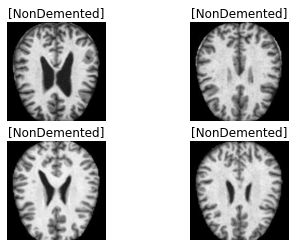

In [38]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('[{}]'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return
        
visualize_model(model_hybrid, num_images=batch_size)